In [1]:
# Импорт библиотек с описанием их назначения
# ee - Google Earth Engine: библиотека для доступа к геопространственным данным
import ee
# torch - PyTorch: фреймворк для машинного обучения
import torch
# torch.nn - модуль PyTorch для работы с нейронными сетями
import torch.nn as nn
# numpy - библиотека для работы с массивами и математическими операциями
import numpy as np
# matplotlib.pyplot - инструмент для визуализации данных
import matplotlib.pyplot as plt
# io.BytesIO - класс для работы с бинарными потоками в памяти
from io import BytesIO
# requests - библиотека для HTTP-запросов
import requests
# rasterio - библиотека для работы с геопространственными растровыми данными
import rasterio
# rasterio.transform.from_bounds - функция для создания географической привязки
from rasterio.transform import from_bounds

In [2]:
# Инициализация Google Earth Engine с указанием проекта
ee.Initialize(project="siberia-forest-monitoring")

In [3]:
# Загрузка спутниковых данных Sentinel-2
def load_sentinel_data(start_date="2023-06-01", end_date="2023-08-31", num_images=3):
    """Загружает и обрабатывает спутниковые снимки Sentinel-2 для анализа вырубки.

    Args:
        start_date (str): Начальная дата периода (формат 'YYYY-MM-DD').
        end_date (str): Конечная дата периода (формат 'YYYY-MM-DD').
        num_images (int): Количество снимков для обработки.

    Returns:
        torch.Tensor: Тензор размера [num_images, 4, 512, 512] с каналами B4, B3, B2, B8.

    Процесс:
        1. Определяет регион Шебалинского района и делит его на 4 субрегиона.
        2. Фильтрует коллекцию Sentinel-2 по дате, облачности и каналам.
        3. Загружает данные каждого субрегиона, проверяет покрытие (>80% ненулевых значений).
        4. Склеивает субрегионы в единый снимок и масштабирует до 512x512 пикселей.
    """
    full_region = [85.7, 51.2, 86.1, 51.4] # Координаты Шебалинского района
    sub_regions = [
        ee.Geometry.Rectangle([85.7, 51.2, 85.95, 51.35]),
        ee.Geometry.Rectangle([85.85, 51.2, 86.1, 51.35]),
        ee.Geometry.Rectangle([85.7, 51.25, 85.95, 51.4]),
        ee.Geometry.Rectangle([85.85, 51.25, 86.1, 51.4]),
    ]

    collection = (
        ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
        .filterBounds(ee.Geometry.Rectangle(full_region))
        .filterDate(start_date, end_date)
        .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 10))
        .select(["B4", "B3", "B2", "B8"])
        .sort("system:time_start")
    )

    count = collection.size().getInfo()
    print(f"Найдено снимков Sentinel-2 за 2023 с облачностью < 10%: {count}")
    if count < num_images:
        raise ValueError(f"Недостаточно снимков: {count} < {num_images}")

    image_list = collection.getInfo()["features"]
    valid_images = []

    for img in image_list:
        date = ee.Date(img["properties"]["system:time_start"]).format("YYYY-MM-dd").getInfo()
        cloudiness = img["properties"].get("CLOUDY_PIXEL_PERCENTAGE", "N/A")
        print(f"Проверка снимка: {date}, Облачность: {cloudiness}%")

        full_tensor_parts = []
        valid = True
        for i, sub_region in enumerate(sub_regions):
            url = ee.Image(img["id"]).getDownloadURL({"region": sub_region, "scale": 30, "format": "NPY"})
            response = requests.get(url)
            data = np.load(BytesIO(response.content))
            bands = np.stack([data["B4"], data["B3"], data["B2"], data["B8"]], axis=0) / 10000.0
            tensor = torch.tensor(bands, dtype=torch.float32)
            non_zero = (tensor > 0).sum().item()
            expected_size = tensor.shape[1] * tensor.shape[2] * 4
            print(f"Субрегион {i}: Размер={tensor.shape}, Ненулевых значений={non_zero}/{expected_size}")
            if non_zero < 0.8 * expected_size:
                valid = False
                print(f"Субрегион {i} отклонён: недостаточно данных")
                break
            full_tensor_parts.append(tensor)

        if valid and len(full_tensor_parts) == 4:
            min_height = min(t.shape[1] for t in full_tensor_parts)
            min_width = min(t.shape[2] for t in full_tensor_parts)
            aligned_parts = [t[:, :min_height, :min_width] for t in full_tensor_parts]
            top_row = torch.cat((aligned_parts[0], aligned_parts[1]), dim=2)
            bottom_row = torch.cat((aligned_parts[2], aligned_parts[3]), dim=2)
            full_tensor = torch.cat((top_row, bottom_row), dim=1)
            full_tensor = torch.nn.functional.interpolate(
                full_tensor.unsqueeze(0), size=(512, 512), mode="bilinear", align_corners=False
            ).squeeze(0)
            non_zero_final = (full_tensor > 0).sum().item()
            print(f"Снимок принят: {date}, Размер={full_tensor.shape}, Ненулевых значений={non_zero_final}")
            valid_images.append(full_tensor)

        if len(valid_images) == num_images:
            break

    if len(valid_images) < num_images:
        raise ValueError(f"Найдено только {len(valid_images)} снимков с достаточным покрытием!")

    return torch.stack(valid_images, dim=0)



In [4]:
# Загрузка климатических и почвенных данных
def load_environmental_data(start_date="2023-06-01", end_date="2023-08-31", num_images=3):
    """Загружает климатические данные для прогноза восстановления леса.

    Args:
        start_date (str): Начальная дата периода.
        end_date (str): Конечная дата периода.
        num_images (int): Количество снимков для синхронизации с Sentinel-2.

    Returns:
        torch.Tensor: Тензор размера [num_images, 3, 512, 512] с температурами, осадками, влажностью.

    Процесс:
        1. Загружает средние данные ERA5 (температура, осадки) и SMAP (влажность почвы).
        2. Нормализует значения: температура в °C, осадки в мм, влажность в относительных единицах.
        3. Интерполирует данные до разрешения 512x512 для совместимости с Sentinel-2.
    """
    geometry = ee.Geometry.Rectangle([85.7, 51.2, 86.1, 51.4])
    climate = (
        ee.ImageCollection("ECMWF/ERA5_LAND/MONTHLY_AGGR")
        .filterBounds(geometry)
        .filterDate(start_date, end_date)
        .select(["temperature_2m", "total_precipitation_sum"])
        .mean()
    )
    soil = (
        ee.ImageCollection("NASA/SMAP/SPL4SMGP/007")
        .filterBounds(geometry)
        .filterDate(start_date, end_date)
        .select(["sm_surface"])
        .mean()
    )

    c_url = climate.getDownloadURL({"region": geometry, "scale": 1000, "format": "NPY"})
    s_url = soil.getDownloadURL({"region": geometry, "scale": 1000, "format": "NPY"})
    c_response, s_response = requests.get(c_url), requests.get(s_url)
    c_data, s_data = np.load(BytesIO(c_response.content)), np.load(BytesIO(s_response.content))
    temp = (c_data["temperature_2m"] - 273.15) / 50.0
    precip = (c_data["total_precipitation_sum"] * 1000) / 1000.0
    soil_moisture = s_data["sm_surface"] / 1.0

    temp_tensor = torch.tensor(temp, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    precip_tensor = torch.tensor(precip, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    soil_tensor = torch.tensor(soil_moisture, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    temp_tensor = torch.nn.functional.interpolate(temp_tensor, size=(512, 512), mode="bilinear").squeeze()
    precip_tensor = torch.nn.functional.interpolate(precip_tensor, size=(512, 512), mode="bilinear").squeeze()
    soil_tensor = torch.nn.functional.interpolate(soil_tensor, size=(512, 512), mode="bilinear").squeeze()
    bands = torch.stack([temp_tensor, precip_tensor, soil_tensor], dim=0)

    return torch.stack([bands.clone() for _ in range(num_images)], dim=0)



In [5]:
# Генерация масок вырубки
def generate_clearcut_masks(sentinel_images):
    """Создаёт целевые маски для обучения модели классификации.

    Args:
        sentinel_images (torch.Tensor): Тензор снимков Sentinel-2.

    Returns:
        torch.Tensor: Тензор масок размера [num_images, 512, 512].

    Процесс:
        1. Вычисляет NDVI (индекс растительности) для каждого снимка.
        2. Присваивает классы: 0 (вырубка) для NDVI < 0.25, 1 (лес) для NDVI > 0.5, 2 (другое) между.
        3. Выводит статистику NDVI и распределение классов.
    """
    masks = []
    for i in range(sentinel_images.shape[0]):
        nir, red = sentinel_images[i, 3], sentinel_images[i, 0]
        ndvi = (nir - red) / (nir + red + 1e-6)
        print(f"Снимок {i}: NDVI min={ndvi.min():.4f}, max={ndvi.max():.4f}, mean={ndvi.mean():.4f}")
        mask = torch.full_like(ndvi, 2, dtype=torch.long)
        mask[ndvi < 0.25] = 0
        mask[ndvi > 0.5] = 1
        masks.append(mask)
    masks = torch.stack(masks)
    print(f"Маски: Вырубка={int((masks == 0).sum())}, Лес={int((masks == 1).sum())}, Другое={int((masks == 2).sum())}")
    return masks



In [6]:
# Генерация целевых значений восстановления
def generate_recovery_targets(sentinel_images, env_data):
    """Создаёт целевые значения времени восстановления для обучения.

    Args:
        sentinel_images (torch.Tensor): Тензор снимков Sentinel-2.
        env_data (torch.Tensor): Тензор климатических данных.

    Returns:
        torch.Tensor: Тензор времени восстановления размера [num_images].

    Процесс:
        1. Рассчитывает NDVI для каждого снимка.
        2. Применяет линейную модель: время = 30 - NDVI * 20, ограничивая диапазон [5, 50] лет.
        3. Выводит статистику NDVI и климатических факторов.
    """
    recoveries = []
    for i in range(sentinel_images.shape[0]):
        nir, red = sentinel_images[i, 3], sentinel_images[i, 0]
        ndvi = (nir - red) / (nir + red + 1e-6)
        temp, precip, soil = env_data[i, 0].mean(), env_data[i, 1].mean(), env_data[i, 2].mean()
        recovery_time = torch.clamp(30 - ndvi.mean() * 20, 5, 50)
        print(f"Снимок {i}: NDVI mean={ndvi.mean():.4f}, Temp={temp:.4f}, Precip={precip:.4f}, Soil={soil:.4f}, "
              f"Recovery={recovery_time:.4f}")
        recoveries.append(recovery_time)
    return torch.stack(recoveries)



In [7]:
# Модель классификации вырубки
class ClearcutCNN(nn.Module):
    """U-Net-подобная свёрточная нейронная сеть для сегментации зон вырубки.

    Архитектура:
        - Два свёрточных слоя с пулингом для извлечения признаков.
        - Dropout для регуляризации.
        - Два транспонированных свёрточных слоя для восстановления разрешения.
        - Выходной слой для классификации на 3 класса.

    Используется для:
        Пиксельной классификации снимков Sentinel-2 на вырубку, лес и другие зоны.
    """
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(4, 16, 3, padding=1), nn.ReLU(),
                                   nn.MaxPool2d(2))
        self.conv2 = nn.Sequential(nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(),
                                   nn.MaxPool2d(2))
        self.dropout = nn.Dropout(0.3)
        self.up1 = nn.ConvTranspose2d(32, 16, 2, stride=2)
        self.up2 = nn.ConvTranspose2d(16, 8, 2, stride=2)
        self.out = nn.Conv2d(8, 3, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.dropout(x)
        x = self.up1(x)
        x = self.up2(x)
        return self.out(x)



In [8]:
# Модель прогнозирования восстановления
class RecoveryModel(nn.Module):
    """Свёрточная нейронная сеть для регрессии времени восстановления леса.

    Архитектура:
        - Один свёрточный слой для извлечения признаков из 7 каналов.
        - Полносвязные слои для регрессии на основе усреднённых данных.

    Используется для:
        Прогнозирования времени восстановления на основе снимков и климата.
    """
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(7, 16, 3, padding=1)
        self.fc = nn.Sequential(
            nn.Linear(16 * 512 * 512, 64), nn.ReLU(),
            nn.Linear(64, 32), nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        x = self.conv(x).relu()
        x = x.view(x.size(0), -1)
        return self.fc(x).squeeze()



In [9]:
# Функция обучения моделей
def train_model(model, inputs, targets, epochs, loss_fn, lr=0.001):
    """Обучает модель с заданной функцией потерь и оптимизатором.

    Args:
        model (nn.Module): Модель для обучения (ClearcutCNN или RecoveryModel).
        inputs (torch.Tensor): Входные данные (снимки или снимки + климат).
        targets (torch.Tensor): Целевые значения (маски или время восстановления).
        epochs (int): Количество эпох обучения.
        loss_fn (nn.Module): Функция потерь (CrossEntropyLoss или MSELoss).
        lr (float): Скорость обучения для оптимизатора Adam.

    Returns:
        nn.Module: Обученная модель.

    Процесс:
        1. Инициализирует оптимизатор Adam.
        2. Выполняет прямой проход, вычисляет потери и обновляет веса.
        3. Выводит прогресс обучения каждые 10% эпох.
    """
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        pred = model(inputs)
        loss = loss_fn(pred, targets)
        loss.backward()
        optimizer.step()
        if (epoch + 1) % (epochs // 10) == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")
    return model



In [10]:
# Основной цикл программы
if __name__ == "__main__":
    """Основной цикл: выполняет загрузку данных, обучение моделей и визуализацию.

    Процесс:
        1. Загружает снимки Sentinel-2 и климатические данные.
        2. Генерирует целевые маски и значения восстановления.
        3. Обучает модели классификации и регрессии.
        4. Выполняет предсказания и визуализирует результаты.
        5. Сохраняет карту вырубки в формате GeoTIFF.
    """
    # Загрузка данных
    sentinel_images = load_sentinel_data()
    env_data = load_environmental_data()
    masks = generate_clearcut_masks(sentinel_images)
    recovery_targets = generate_recovery_targets(sentinel_images, env_data)
    combined_inputs = torch.cat((sentinel_images, env_data), dim=1)

    # Обучение моделей
    clearcut_model = ClearcutCNN()
    clearcut_model = train_model(
        clearcut_model, sentinel_images, masks, epochs=300,
        loss_fn=nn.CrossEntropyLoss(weight=torch.tensor([20.0, 1.0, 5.0]))
    )

    recovery_model = RecoveryModel()
    recovery_model = train_model(
        recovery_model, combined_inputs, recovery_targets, epochs=50, loss_fn=nn.MSELoss()
    )

    # Предсказания
    clearcut_model.eval()
    recovery_model.eval()
    with torch.no_grad():
        clearcut_pred = clearcut_model(sentinel_images)[0].argmax(dim=0).numpy()
        recovery_pred = recovery_model(combined_inputs)[0].item()
        print(f"Предсказанные классы: Вырубка={int((clearcut_pred == 0).sum())}, "
              f"Лес={int((clearcut_pred == 1).sum())}, Другое={int((clearcut_pred == 2).sum())}")
        print(f"Предсказанное время восстановления: {recovery_pred:.2f} лет")


Найдено снимков Sentinel-2 за 2023 с облачностью < 10%: 29
Проверка снимка: 2023-06-03, Облачность: 2.631423%
Субрегион 0: Размер=torch.Size([4, 566, 591]), Ненулевых значений=0/1338024
Субрегион 0 отклонён: недостаточно данных
Проверка снимка: 2023-06-03, Облачность: 3.170832%
Субрегион 0: Размер=torch.Size([4, 566, 591]), Ненулевых значений=0/1338024
Субрегион 0 отклонён: недостаточно данных
Проверка снимка: 2023-06-03, Облачность: 1.278284%
Субрегион 0: Размер=torch.Size([4, 566, 591]), Ненулевых значений=1338018/1338024
Субрегион 1: Размер=torch.Size([4, 565, 590]), Ненулевых значений=1333165/1333400
Субрегион 2: Размер=torch.Size([4, 566, 590]), Ненулевых значений=1335752/1335760
Субрегион 3: Размер=torch.Size([4, 565, 589]), Ненулевых значений=1330940/1331140
Снимок принят: 2023-06-03, Размер=torch.Size([4, 512, 512]), Ненулевых значений=1048562
Проверка снимка: 2023-06-03, Облачность: 0.491335%
Субрегион 0: Размер=torch.Size([4, 566, 591]), Ненулевых значений=47544/1338024
Субре

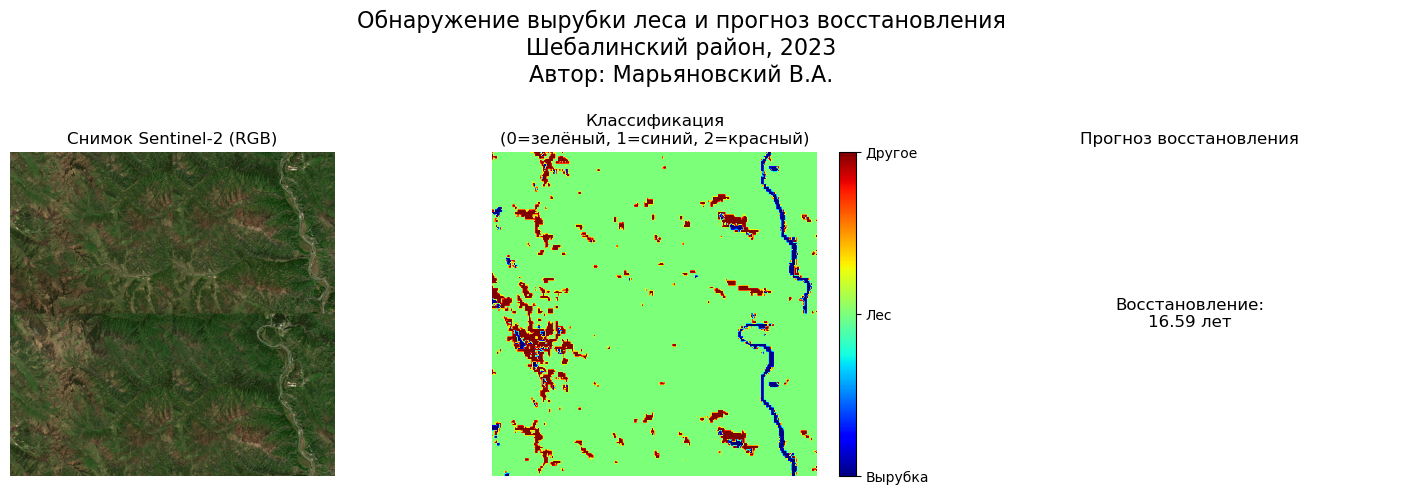

In [11]:
    # Визуализация
    rgb_image = sentinel_images[0, :3].permute(1, 2, 0).numpy()
    rgb_image = np.clip(rgb_image * 5.0, 0, 1)

    plt.figure(figsize=(15, 5))
    plt.suptitle("Обнаружение вырубки леса и прогноз восстановления\n"
                 "Шебалинский район, 2023\nАвтор: Марьяновский В.А.", fontsize=16)

    plt.subplot(1, 3, 1)
    plt.imshow(rgb_image)
    plt.title("Снимок Sentinel-2 (RGB)")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(clearcut_pred, cmap="jet", vmin=0, vmax=2)
    plt.title("Классификация\n(0=зелёный, 1=синий, 2=красный)")
    plt.axis("off")
    cbar = plt.colorbar(ticks=[0, 1, 2])
    cbar.ax.set_yticklabels(["Вырубка", "Лес", "Другое"])

    plt.subplot(1, 3, 3)
    plt.text(0.5, 0.5, f"Восстановление:\n{recovery_pred:.2f} лет", ha="center", va="center", fontsize=12)
    plt.title("Прогноз восстановления")
    plt.axis("off")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # Сохранение результатов в GeoTIFF
    transform = from_bounds(85.7, 51.2, 86.1, 51.4, clearcut_pred.shape[1],
                            clearcut_pred.shape[0])
    with rasterio.open(
        "shebalino_clearcut_2023.tif", "w", driver="GTiff",
        height=clearcut_pred.shape[0], width=clearcut_pred.shape[1], count=1,
        dtype=clearcut_pred.dtype, crs="EPSG:4326", transform=transform
    ) as dst:
        dst.write(clearcut_pred, 1)
